In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

import tensorflow as tf

from tensorflow.keras import layers as klayer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random

In [3]:
y_labels = np.array(['airplane', 'automobile',
                     'bird', 'cat',
                     'deer', 'dog',
                     'frog', 'horse',
                     'ship', 'truck'], dtype='S10')
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


Sample input data:


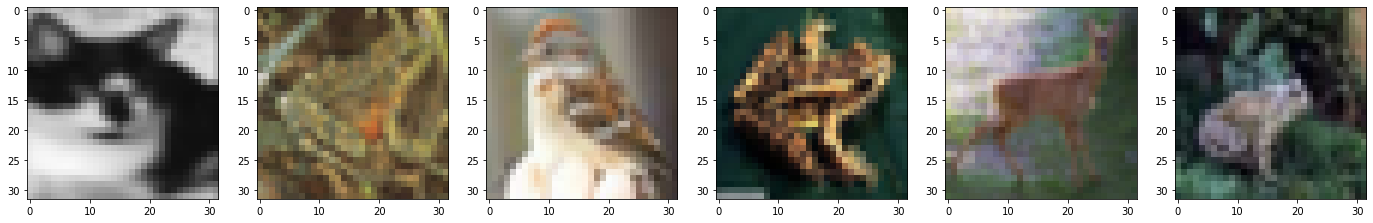

- Number of input samples for training: 50000
  ...and for validation: 10000
- Shape of each input sample: (32, 32, 3)
- Pixel values range between 0 and 255


In [4]:
print('Sample input data:')
fig = plt.figure(figsize=(24, 24))
row = 1
col = 6
pos = 1
for idx in random.sample(range(1, 50000), 6):
  img = X_train[idx]
  fig.add_subplot(row, col, pos)
  pos += 1
  plt.imshow(img, cmap='gist_gray', interpolation='nearest')
plt.show()

print('- Number of input samples for training: {}'.format(len(X_train)))
print('  ...and for validation: {}'.format(len(X_test)))
print('- Shape of each input sample: {}'.format(X_train.shape[1:]))
print('- Pixel values range between {} and {}'.format(X_train.min(), X_train.max()))

In [5]:
#We should normalize the data so that all the input features are on the same scale(Generally between 0 and 1). As the pixel values range between 0 to 255, we normalize the value of each pixel by dividing it by 255
X_train = X_train/255
y_train = to_categorical(y_train)

X_test = X_test/255
y_test = to_categorical(y_test)

print('- Pixel values now range between {} and {}'.format(X_train.min(), X_train.max()))

- Pixel values now range between 0.0 and 1.0


In [6]:
#Define the architecture of the neural network.
def get_model(
              filter_size=3,
              padding='same',
              num_classes=10,
             ):
    
    model = Sequential()  # Let's stack the layers of our CNN as usual
    
    # Layer 1:
    model.add(
                # Add your first conv-layer here
                klayer.Conv2D(filters = 32, kernel_size = (5, 5), strides=(1, 1), padding='valid', activation='relu',
                input_shape = (32, 32, 3))
            )

    # Layer 2: Down sampling
    model.add(
                # Add pooling layer
                klayer.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding='valid')
             )

    # Layer 3:
    model.add(
                # Second conv-layer. Usually, the deeper the layer, the more "channels" you add.
                klayer.Conv2D(filters = 64, kernel_size = (3, 3), strides=(1, 1), padding='valid',
                activation='relu')
            )

    # Layer 4: Downsampling
    model.add(
                # Another Pooling layer. How big is the spatial resolution up to this point?
                klayer.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding='valid')
             )

    # Layer 5:
    model.add(
                # Third conv-layer.
                klayer.Conv2D(filters = 80, kernel_size = (1, 1), strides=(1, 1), padding='valid',
                activation='relu')
             )

    # Reduce spatial dimensions...
    model.add(klayer.Flatten())
    # Layer 6: Fully Connected Layer:
    model.add(
                # Only FC layer here.
                klayer.Dense(288, input_shape = (2880,), activation='relu')
             )
        
    # Layer 7: appropriate output layer
    model.add(
                # Output layer. Remember what's the right size and activation for this one?
                klayer.Dense(10, activation='softmax')
             )
    
    return model
  
model = get_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 80)          5200      
_________________________________________________________________
flatten (Flatten)            (None, 2880)              0         
_________________________________________________________________
dense (Dense)                (None, 288)               8

In [7]:
def train_model(
                model,
                trainsamples,
                valsamples,
                batch_size,
                epochs=10,
                lr=1e-3,
                optimizer=None,
                log_per_epoch=1,
                n_trainsamples=50000,
                n_valsamples=10000
                ):
    if optimizer is None or 'sgd':
        optimizer = SGD(lr=lr, momentum=0.95)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    stepsperepoch = n_trainsamples // (batch_size * log_per_epoch)
    subepochs = epochs * log_per_epoch
    
    mhistory = model.fit_generator(trainsamples,
                               steps_per_epoch=stepsperepoch,
                               validation_data=valsamples,
                               validation_steps=n_valsamples // batch_size,
                               epochs=subepochs)
    return mhistory

In [8]:
batch_size = 64
epochs = 4
lpe = 5

datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1,
	width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1,
	horizontal_flip=True, fill_mode="nearest")

#Data agumentation for sending the images in batchs.
trainsamples = datagen.flow(X_train, y_train, batch_size)
valsamples = datagen.flow(X_test, y_test, batch_size)

hist = train_model(
                   model,
                   trainsamples,
                   valsamples,
                   batch_size,
                   log_per_epoch = lpe,
                   epochs = epochs,
                   lr=1e-2,
                   optimizer='sgd'
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
156/156 [==============================] - 10s 61ms/step - loss: 2.1088 - accuracy: 0.2250 - val_loss: 1.8954 - val_accuracy: 0.2920
Epoch 2/20
156/156 [==============================] - 9s 58ms/step - loss: 1.8052 - accuracy: 0.3408 - val_loss: 1.7836 - val_accuracy: 0.3484
Epoch 3/20
156/156 [==============================] - 9s 58ms/step - loss: 1.6784 - accuracy: 0.3929 - val_loss: 1.6206 - val_accuracy: 0.4118
Epoch 4/20
156/156 [==============================] - 9s 59ms/step - loss: 1.5687 - accuracy: 0.4278 - val_loss: 1.5620 - val_accuracy: 0.4402
Epoch 5/20
156/156 [==============================] - 9s 59ms/step - loss: 1.5194 - accuracy: 0.4442 - val_loss: 1.5039 - val_accuracy: 0.4433
Epoch 6/20
156/156 [==============================] - 9s 60ms/step - loss: 1.4926 - accuracy: 0.4604 - val_loss: 1.4726 - val_accuracy: 0.4787
Epoch 7/20
156/156 [==============================] - 9s 59ms/ste

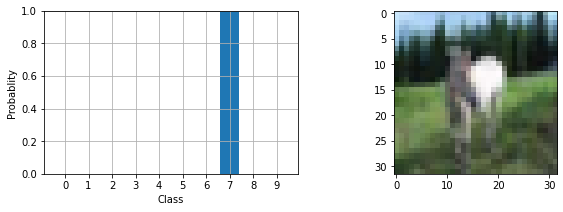

Labels : [b'airplane' b'automobile' b'bird' b'cat' b'deer' b'dog' b'frog' b'horse'
 b'ship' b'truck']


In [13]:
#Pick a number between 0 and 10000
img_idx = random.randint(0, 10000)

#Pick how much noise do you want to add to the sample before passing it through the network
noise = 0.0  #Number between 0 and 1

test_sample = X_test[img_idx][np.newaxis]
#Predict the test sample.
pred = model.predict(test_sample)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plt.imshow(X_test[img_idx], cmap='gist_gray', interpolation='nearest')
plt.sca(axes[0])
plt.grid(True, axis='both')
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Probablity")
plt.bar(range(10), pred[0])
_ = plt.xticks(range(10), range(10))
plt.ylim(0, 1)
plt.show()
print('Labels : {}'.format(y_labels))